# This notebook is used to perform experiments with PCA and t-SNE
It holds all code to reproduce the experiments related to dimensionality reduction applied on the last-layer activations of our models.

In [70]:
# imports
import os
import random
import torch
import timm
import cv2

import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision import transforms
from data_utils.data_stats import MEAN_DICT, STD_DICT, CLASS_DICT
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
from torchvision import datasets, transforms
from data_utils.data_stats import *
from utils.metrics import AverageMeter, topk_acc
from torchmetrics import Accuracy
from models.resnet import resnet18
from models.networks import get_model
from datasets import load_dataset
from PIL import Image

In [71]:
# Hyperparameters
DATASET_NAME = "cifar10"  # only allow cifar10
DEVICE = "cpu"  # one of: cpu, cuda:0
BATCH_SIZE = 256

In [72]:
# CIFAR10 Dataset Configuration
dataset_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]
dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Setup dataloader
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=0)
input_size = 32

num_classes = CLASS_DICT[DATASET_NAME]
assert len(dataset_classes) == num_classes

mean = MEAN_DICT[DATASET_NAME]
std = STD_DICT[DATASET_NAME]

input_transform = transforms.Normalize(mean / 255., std / 255.)

torch.backends.cuda.matmul.allow_tf32 = True

Files already downloaded and verified


In [73]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model, input_size):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.resize = transforms.Resize(input_size)

    def forward(self, x):
        x = self.resize(x)
        x = self.model(x)
        return x

class MLPWrapper(torch.nn.Module):
    def __init__(self, model, input_size):
        super(MLPWrapper, self).__init__()
        self.model = model
        self.resize = transforms.Resize(input_size)

    def forward(self, x):
        x = self.resize(x)
        x = x.flatten(1)
        x = self.model(x)
        return x

if not os.path.exists("checkpoints"):
        os.mkdir("checkpoints")

In [74]:
resnet_model = resnet18(pretrained=True)
    
mlp_architecture = 'B_12-Wi_1024'  # B_12-Wi_512
mlp_resolution = 64  # Resolution of fine-tuned model (64 for all models we provide)
mlp_checkpoint = 'in21k_cifar10'  # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10
mlp_model = get_model(architecture=mlp_architecture, resolution=mlp_resolution, num_classes=num_classes,
                          checkpoint=mlp_checkpoint)
mlp_model = MLPWrapper(mlp_model, mlp_resolution)
    
vit_path = "./models/ViT_cifar10.pt"
vit_checkpoint = torch.load(vit_path, map_location=torch.device(DEVICE))
vit_model = timm.create_model("vit_tiny_patch16_224", pretrained=True)
vit_model.head = torch.nn.Linear(vit_model.head.in_features, num_classes)
vit_model = torch.nn.DataParallel(vit_model) # make parallel
vit_model.load_state_dict(vit_checkpoint['model'])

vit_model = ModelWrapper(vit_model, 224)

models = {"CNN": resnet_model, "MLP": mlp_model, "VIT": vit_model}

Weights already downloaded
Load_state output <All keys matched successfully>


In [ ]:
# sanity the check the model accuracies.
for name, model in models.items():
    model.eval()
    total_acc = AverageMeter()
    accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    with torch.no_grad():
        for ims, targs in tqdm(data_loader, desc=f"{DATASET_NAME} Evaluation {name}"):
            preds = model(input_transform(ims))
            acc, _ = topk_acc(preds, targs, k=1, avg=True)
            total_acc.update(acc, ims.shape[0])

    print(f"Model {name} Accuracy: %2.2f %%" % total_acc.get_avg(percentage=True))

In [76]:
# returns samples_per_class samples for each class.
def get_random_images(samples_per_class: int):
    random_samples = torch.empty((num_classes, samples_per_class, 3, input_size, input_size))
    classes_seen = np.zeros(num_classes, dtype=int)
    
    for img, targs in data_loader:
        num_samples = img.shape[0]
        for i in range(num_samples):
            image, label = img[i], targs[i]
            amount_per_class = classes_seen[label]
            if amount_per_class < samples_per_class:
                random_samples[label, amount_per_class] = image
                classes_seen[label] += 1
                if np.all(classes_seen == samples_per_class):
                    return random_samples
    print("Attention: Did not find all samples!")
    return random_samples[random_indices], random_indices

Get the samples.

In [77]:
SAMPLES_PER_CLASS = 25

samples = get_random_images(SAMPLES_PER_CLASS)

Compute the activations for the samples on all models, store the predicted classes and probabilities alongside.

In [78]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

resnet_model.layer4.register_forward_hook(get_activation("CNN"))  # for ResNet18
mlp_model.model.blocks[11].register_forward_hook(get_activation("MLP"))  # for MLP
vit_model.model.module.fc_norm.register_forward_hook(get_activation("VIT"))  # for ViT

for name in models.keys():
    models[name].eval()

intermediate_values = {"CNN": torch.empty((num_classes, SAMPLES_PER_CLASS, 2048), dtype=float), 
                       "MLP": torch.empty((num_classes, SAMPLES_PER_CLASS, 1024), dtype=float), 
                       "VIT": torch.empty((num_classes, SAMPLES_PER_CLASS, 192), dtype=float)}
predicted_classes = {"CNN": torch.empty((num_classes, SAMPLES_PER_CLASS), dtype=int), 
                     "MLP": torch.empty((num_classes, SAMPLES_PER_CLASS), dtype=int), 
                     "VIT": torch.empty((num_classes, SAMPLES_PER_CLASS), dtype=int)}
predicted_probabilities = {"CNN": torch.empty((num_classes, SAMPLES_PER_CLASS), dtype=float), 
                           "MLP": torch.empty((num_classes, SAMPLES_PER_CLASS), dtype=float), 
                           "VIT": torch.empty((num_classes, SAMPLES_PER_CLASS), dtype=float)}

with torch.no_grad():
    for i in range(num_classes):
        ims = samples[i]

        for name in ["CNN", "MLP", "VIT"]:
            preds = models[name](input_transform(ims))
            probabilities = torch.nn.functional.softmax(preds, dim=-1).squeeze()
            top_probability = torch.max(probabilities, dim=-1).values
            predicted_class = torch.argmax(preds, dim=-1)
            
            intermediate_values[name][i] = activation[name].flatten(1)
            predicted_classes[name][i] = predicted_class
            predicted_probabilities[name][i] = top_probability

Perform dimensionality reduction and visualize the plots.

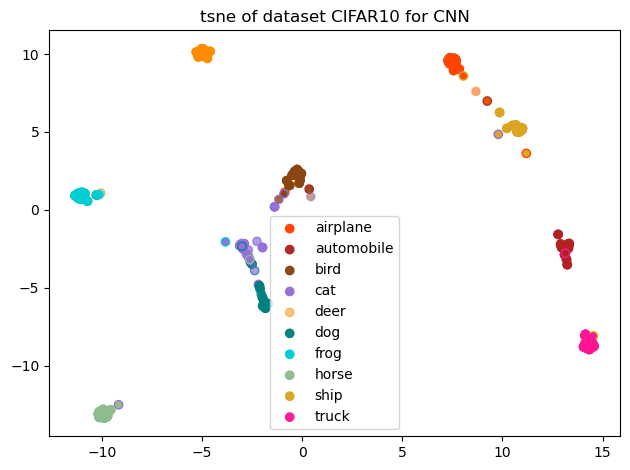

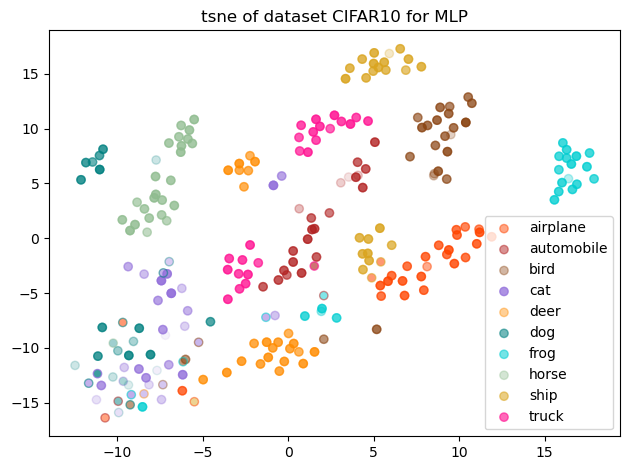

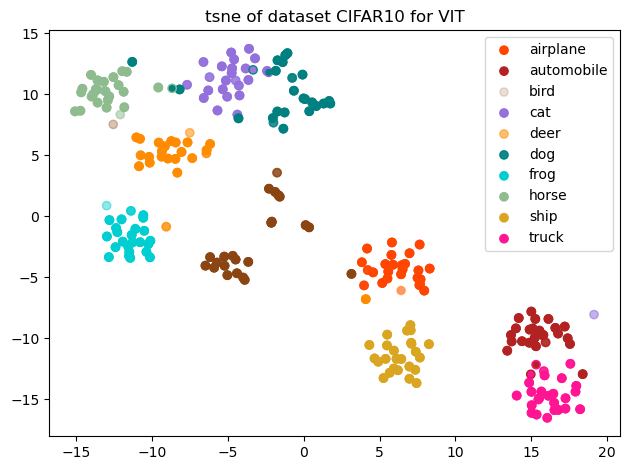

In [180]:
METHOD_NAME = "tsne"  # pca or tsne

if not (METHOD_NAME == "pca" or METHOD_NAME == "tsne"):
    print(f"Method {METHOD_NAME} not found! Set to default value (PCA)")
    METHOD_NAME = "pca"
else:
    if METHOD_NAME == "pca":
        method = PCA(n_components=2)
    elif METHOD_NAME == "tsne":
        method = TSNE(n_components=2, random_state=0)


colors = [
    '#FF4500',  # Orange Red
    '#B22222',  # Firebrick
    '#8B4513',  # Brown
    '#9370DB',  # Medium Purple
    '#FF8C00',  # Dark Orange
    '#008080',  # Teal
    '#00CED1',  # Dark Turquoise
    '#8FBC8F',  # Dark Sea Green
    '#DAA520',  # Goldenrod
    '#FF1493'   # Deep Pink
]

assert len(colors) == num_classes

for name in models.keys():
    X = method.fit_transform(intermediate_values[name].view((num_classes * SAMPLES_PER_CLASS, -1)))
    
    # print(f"{name}: Explained variance ratio (first two components): {str(method.explained_variance_ratio_)}")

    plt.figure()
    
    for i in range(num_classes):
        correct_prediction = predicted_classes[name][i] == i
        plt.scatter(
            X[i * SAMPLES_PER_CLASS:(i+1) * SAMPLES_PER_CLASS, 0][correct_prediction], 
            X[i * SAMPLES_PER_CLASS:(i+1) * SAMPLES_PER_CLASS, 1][correct_prediction], 
            alpha=predicted_probabilities[name][i] ** 2,
            label=dataset_classes[i],
            color=colors[i],
            edgecolors=colors[i]
        )
        for j in range(num_classes):
            missprediction = predicted_classes[name][i] == j
            plt.scatter(
                X[i * SAMPLES_PER_CLASS:(i+1) * SAMPLES_PER_CLASS, 0][missprediction], 
                X[i * SAMPLES_PER_CLASS:(i+1) * SAMPLES_PER_CLASS, 1][missprediction], 
                alpha=predicted_probabilities[name][i] ** 2, 
                label=None,
                color=colors[j], edgecolors=colors[i]
            )
            # find and visualize a particular sample
            """
            if name == "VIT" and i == 4 and j == 4:
                selection_matrix = np.zeros(SAMPLES_PER_CLASS).astype(bool)
                selection_matrix[0] = True
                
                missprediction = predicted_classes[name][i] == j
                print(missprediction)
                
                plt.scatter(
                    X[i * SAMPLES_PER_CLASS:(i+1) * SAMPLES_PER_CLASS, 0][selection_matrix], 
                    X[i * SAMPLES_PER_CLASS:(i+1) * SAMPLES_PER_CLASS, 1][selection_matrix], 
                    label=None,
                    color='black'
                )
            """

    # plt.axis('off')  # to export
    plt.legend(loc="best", shadow=False, scatterpoints=1)  # comment out to export
    plt.title(f"{METHOD_NAME} of dataset CIFAR10 for {name}")
    plt.tight_layout()
    plt.show()

Visualize a particular example from the plot using the true label and the index of the sample.

In [99]:
# reshape to get input tensor for a particular image
def get_input_tensor(img):
    img = input_transform(img).unsqueeze(0)
    return img

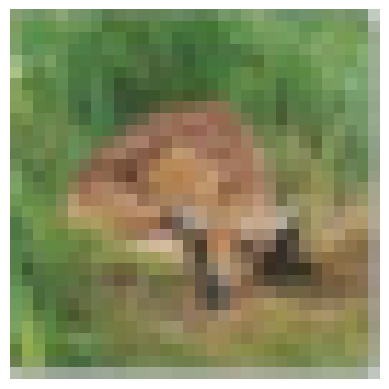

True label 'deer'. Predicted 'deer' with probability 74.28%'


In [171]:
true_label = 4
index = 0

image = samples[true_label][index]
image_np = image.numpy().transpose((1, 2, 0))
plt.imshow(image_np)
plt.axis('off')
plt.show()

# prediction of our model
models["VIT"].eval()

with torch.no_grad():
    output = models["VIT"](get_input_tensor(image))
    probabilities = torch.nn.functional.softmax(output, dim=-1).squeeze()
    predicted_class = torch.argmax(probabilities).item()

    predicted_label = dataset_classes[predicted_class]
    
    print(f"True label '{dataset_classes[true_label]}'. Predicted '{predicted_label}' with probability {(probabilities[predicted_class] * 100):.2f}%'")